#### Import necessary packages

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import logging
import time

#### Check mps is avaliable

In [79]:
# Check mps is avaliable
if not torch.backends.mps.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('mps')

print(f"Using device: {device}")

Using device: mps


#### Fix random seed

In [80]:
# Set random seed
seed_np = np.random.seed(2)
seed = torch.manual_seed(2)

#### Process data

In [81]:
# Load SST data from the NetCDF file using xarray
data_path = './sst.mon.mean.trefadj.anom.1880to2018.nc'
ds = xr.open_dataset(data_path)
sst_data = ds['sst'].sel(time=slice('1880-01-01', '2018-12-31')).isel(lat=slice(85, 95), lon=slice(190, 240))  # Slice the data (lat 85~95 for 5S~5N degrees, lon 190~240 for 120W~170W degrees)

# Reshape SST data to be (-1, 12, 10, 50) for (years, months, lat, lon)
years = sst_data.shape[0] // 12
sst_data = sst_data.values.reshape(years, 12, 10, 50)

# Function to process anomaly data and get labels based on specified thresholds
def get_anomaly_labels(file_path, start_year=1880, end_year=2018):
    # Load label data
    sst_labels_raw = pd.read_csv(file_path, delim_whitespace=True, header=None)

    # Set columns (Years and Months)
    columns = ['Year'] + [f'Month_{i}' for i in range(1, 13)]
    sst_labels_raw.columns = columns
    sst_labels_raw.set_index('Year', inplace=True)

    # Filter years from start_year to end_year
    sst_labels_raw = sst_labels_raw.loc[start_year:end_year]

    # Replace placeholder values with NaN and interpolate or remove
    sst_labels_raw.replace(-99.99, np.nan, inplace=True)
    sst_labels_raw.interpolate(method='linear', limit_direction='both', axis=0, inplace=True)

    # Calculate the 3-month rolling mean
    sst_labels = sst_labels_raw.rolling(window=3, axis=1, center=True).mean()

    # Function to label each year based on the majority of 3-month averages
    def label_year(row):
        labels = []
        for i in range(1, 11):  # Adjusted range to handle rolling window
            three_month_avg = row[i:i+3].mean()  # Adjust to start from first complete window
            if three_month_avg >= 0.5:
                labels.append(2)  # El Niño
            elif three_month_avg <= -0.5:
                labels.append(0)  # La Niña
            else:
                labels.append(1)  # Neutral
        
        # Determine the most frequent label for the year
        return max(set(labels), key=labels.count)

    # Apply the labeling function to each year
    labels = sst_labels.apply(label_year, axis=1).reset_index()
    labels.columns = ['Year', 'Label']

    return labels


data_path = './nino34.long.anom.data.txt'
sst_labels = get_anomaly_labels(data_path)

print(sst_data.shape)
print(sst_labels.shape)
print(sst_labels['Label'].value_counts())

(139, 12, 10, 50)
(139, 2)
Label
1    80
0    39
2    20
Name: count, dtype: int64


#### Hyperparameters

In [82]:
# Hyperparameters
params = {
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "epochs": 2000,
    "batch_size": 32,
    "num_workers": 0,  # have some problems with num_workers > 0
    "test_size": 0.1,  # use 10% of the data for testing
    "eval_size": 0.222, # 0.222 * 0.9 ≈ 0.2 of the data for validation
}

#### Setting dataset

In [83]:
# Splitting the dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(sst_data, sst_labels, test_size=params["test_size"], random_state=seed_np)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=params["eval_size"], random_state=seed_np)

# Check shapes
print(X_train.shape, y_train.shape)  # (97, 12, 180, 360) (97, 2)
print(X_val.shape, y_val.shape)  # (28, 12, 180, 360) (28, 2)
print(X_test.shape, y_test.shape)  # (14, 12, 180, 360) (14, 2)


class SSTDataset(Dataset):
    def __init__(self, X, y):
        y = y.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y[:, 1], dtype=torch.long)  # Extract only the label column

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]  # (12, 180, 360), (2)


# Initialize DataLoader objects again to ensure correctness
train_loader = DataLoader(SSTDataset(X_train, y_train), batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers'])
val_loader = DataLoader(SSTDataset(X_val, y_val), batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'])
test_loader = DataLoader(SSTDataset(X_test, y_test), batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'])


(97, 12, 10, 50) (97, 2)
(28, 12, 10, 50) (28, 2)
(14, 12, 10, 50) (14, 2)


#### Define model

In [84]:
# Model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(12, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(4, 2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout1 = nn.Dropout(0.3)  # Dropout layer after convolutional layers
        self.dropout2 = nn.Dropout(0.3)  # Dropout layer before final fully connected layer
        
        # Calculate the size after pooling layers
        self.num_flat_features = 2 * (10 // 8) * (50 // 8)  # Adjusted for additional pooling layer
        
        self.fc1 = nn.Linear(self.num_flat_features, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 3)  # Output layer for 3 classes: El Niño, La Niña, Neutral

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)  # Apply dropout after pooling layers
        
        x = x.view(-1, self.num_flat_features)
        
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)  # Apply dropout after fully connected layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output logits for three classes
        return x

#### Configurations

In [85]:
# Initialize model, optimizer, and loss function
model = CNN().to(device)  # mps
optimizer = optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"], betas=(0.8, 0.8))
criterion = nn.CrossEntropyLoss()

#### Training and Testing

In [86]:
# Configure logging
logging.basicConfig(filename='training.log', level=logging.INFO)

# Loss array to keep track of train and validation losses
Loss = np.zeros((params["epochs"], 2))  # epochs, train/test
Accuracy = np.zeros((params["epochs"], 2))  # epochs, train/test

def calculate_accuracy(labels, preds):
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy


def train_model():
    logging.info(f'Starting training, Epochs: {params["epochs"]}, Batch Size: {params["batch_size"]}, Learning Rate: {params["lr"]}, Weight Decay: {params["weight_decay"]}')
    best_val_loss = float('inf')
    start_time = time.time()

    for epoch in tqdm(range(params["epochs"]), desc='Training progress'):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        Loss[epoch, 0] = avg_train_loss
        Accuracy[epoch, 0] = train_accuracy

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        Loss[epoch, 1] = avg_val_loss
        Accuracy[epoch, 1] = val_accuracy

        # Log the epoch results
        message = f'Epoch {epoch + 1}/{params["epochs"]}\n'
        message += f'           Train set - loss: {avg_train_loss:.4f}, accuracy: {train_accuracy:.4f}\n'
        message += f'           Validation set - loss: {avg_val_loss:.4f}, accuracy: {val_accuracy:.4f}\n'

        # Write the message to the log file
        logging.info(message)

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            logging.info('Validation loss decreased, saving model...')

    # Calculate total training time
    train_time = time.time() - start_time
    print(f'Training time for {params["epochs"]} epochs: {train_time:.2f} seconds')


def test_model(model_path='best_model.pth'):
    # Load the best model for testing
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Testing phase
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    accuracy = correct / total * 100
    print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Training
train_model()

# Evaluate the model
test_model()

Training progress: 100%|██████████| 2000/2000 [01:07<00:00, 29.74it/s]

Training time for 2000 epochs: 67.25 seconds
Test Loss: 0.3916, Accuracy: 85.71%


#### Visualize result

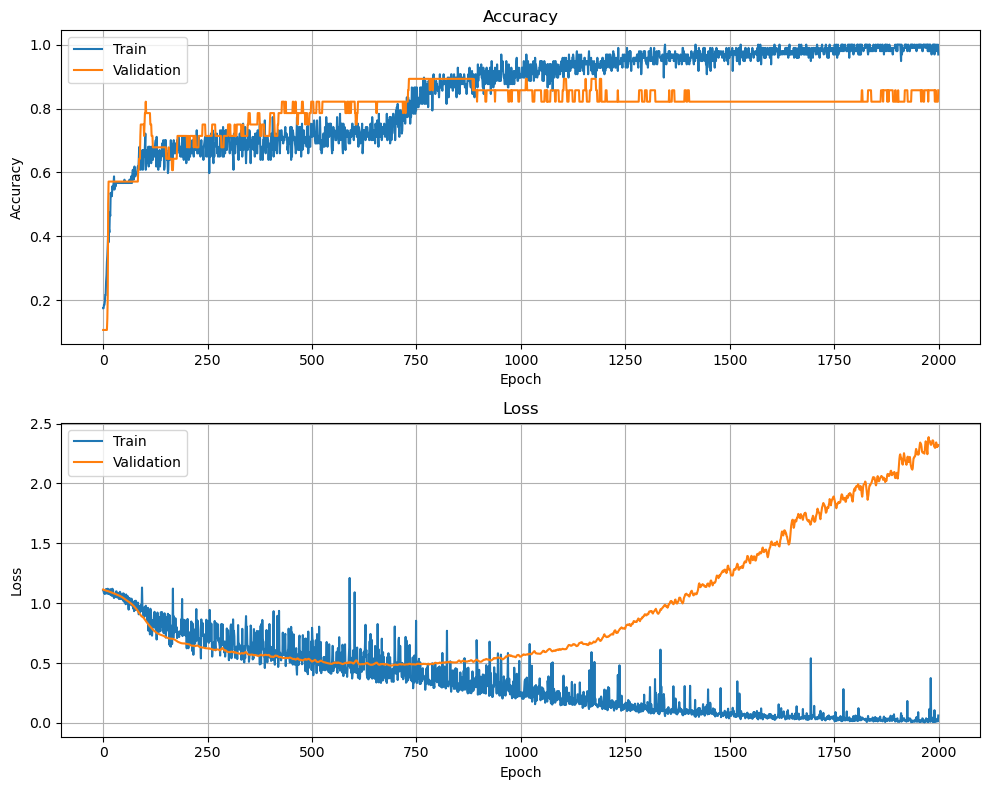

In [87]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(Accuracy)
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'])
axs[0].grid(True)

# Plot Loss
axs[1].plot(Loss)
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Validation'])
axs[1].grid(True)

plt.tight_layout()
plt.savefig('hw9_training_result.png')